## 1. Import the libraries, load dataset, print shape of data, data description

In [31]:
import pandas as pd
import numpy as np
import seaborn as sns 
import matplotlib.pyplot as plt
import nltk 
import nltk.corpus
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer,LancasterStemmer
import string
import re
from nltk import word_tokenize, sent_tokenize
from keras.preprocessing.text import Tokenizer
from sklearn.model_selection import train_test_split
import re, string, unicodedata
from bs4 import BeautifulSoup

In [32]:
df = pd.read_csv('Tweets.csv')

In [33]:
df.shape

(14640, 15)

In [34]:
df.describe()
#there are missing values for negativereason_confidence column. 
#Since we are going to drop this column, no need to remove or transform missing cells

,tweet_id,airline_sentiment_confidence,negativereason_confidence,retweet_count
count,1.464000e+04,14640.000000,10522.000000,14640.000000
mean,5.692184e+17,0.900169,0.638298,0.082650
std,7.791112e+14,0.162830,0.330440,0.745778
min,5.675883e+17,0.335000,0.000000,0.000000
25%,5.685592e+17,0.692300,0.360600,0.000000
50%,5.694779e+17,1.000000,0.670600,0.000000
75%,5.698905e+17,1.000000,1.000000,0.000000
max,5.703106e+17,1.000000,1.000000,44.000000


In [35]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14640 entries, 0 to 14639
Data columns (total 15 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   tweet_id                      14640 non-null  int64  
 1   airline_sentiment             14640 non-null  object 
 2   airline_sentiment_confidence  14640 non-null  float64
 3   negativereason                9178 non-null   object 
 4   negativereason_confidence     10522 non-null  float64
 5   airline                       14640 non-null  object 
 6   airline_sentiment_gold        40 non-null     object 
 7   name                          14640 non-null  object 
 8   negativereason_gold           32 non-null     object 
 9   retweet_count                 14640 non-null  int64  
 10  text                          14640 non-null  object 
 11  tweet_coord                   1019 non-null   object 
 12  tweet_created                 14640 non-null  object 
 13  t

In [36]:
df.negativereason.value_counts()
#Shows Customer service issue was the most reason for negative reasons

Customer Service Issue         2910
Late Flight                    1665
Can't Tell                     1190
Cancelled Flight                847
Lost Luggage                    724
Bad Flight                      580
Flight Booking Problems         529
Flight Attendant Complaints     481
longlines                       178
Damaged Luggage                  74
Name: negativereason, dtype: int64

In [37]:
df.airline_sentiment.value_counts()
#Overall sentiment from this dataset, negative sentiment consist of about double the sum of neutral and positive sentiment.

negative    9178
neutral     3099
positive    2363
Name: airline_sentiment, dtype: int64

Text(0.5, 1.0, 'Length Histogram')

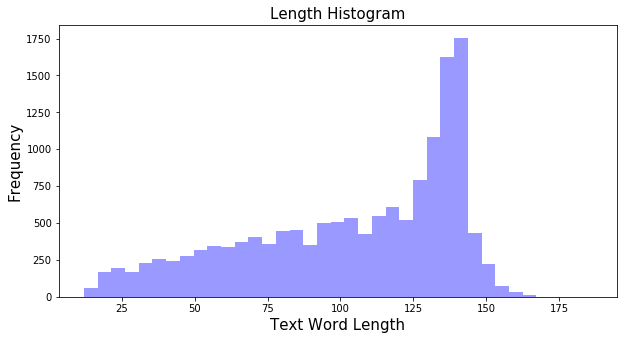

In [38]:
df['len_text'] = df['text'].apply(len)
plt.figure(figsize=(10,5))
sns.distplot(df['len_text'],kde=False,color='blue',hist=True)
plt.xlabel("Text Word Length",size=15)
plt.ylabel("Frequency",size=15)
plt.title("Length Histogram",size=15)
#Shows that high frequency of "Text" have text word length in between 125 words to about 140 words.

## 2. Understand of data-columns

a. Drop all other columns except “text” and “airline_sentiment”.

In [39]:
#Create data table with only "text" and "airline_sentiment"
df_rev0 = df[['text','airline_sentiment']]

b. Check the shape of data.

In [40]:
df_rev0.shape
#Below shows more checks of new data

(14640, 2)

In [41]:
df_rev0.isnull().sum()
#Shows no null values that shows as 1 (True).

text                 0
airline_sentiment    0
dtype: int64

Text(0.5, 1.0, 'Sentiment Count')

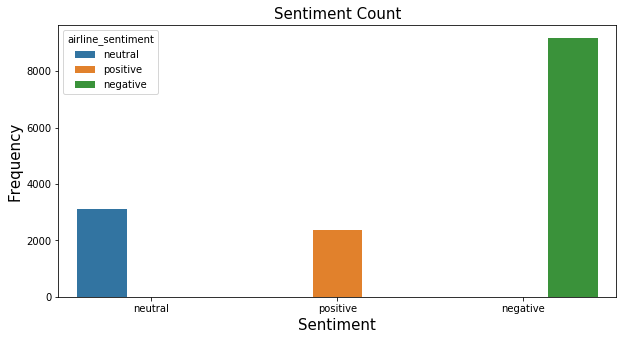

In [42]:
#Shows countplot of three sentiments to see what sentiment is mostly consist of int he dataset
plt.figure(figsize=(10,5))
ax = sns.countplot(x="airline_sentiment", data=df_rev0,hue="airline_sentiment")
plt.xlabel("Sentiment",size=15)
plt.ylabel("Frequency",size=15)
plt.title("Sentiment Count",size=15)

In [43]:
df_rev0['airline_sentiment'].value_counts(normalize=True)
#63% are negative sentiment, which is a lot of negative comments.

negative    0.626913
neutral     0.211680
positive    0.161407
Name: airline_sentiment, dtype: float64

c. Print first 5 rows of data.

In [44]:
df_rev0.head()

,text,airline_sentiment
0,@VirginAmerica What @dhepburn said.,neutral
1,@VirginAmerica plus you've added commercials t...,positive
2,@VirginAmerica I didn't today... Must mean I n...,neutral
3,@VirginAmerica it's really aggressive to blast...,negative
4,@VirginAmerica and it's a really big bad thing...,negative


## 3. Text pre-processing: Data preparation. 

#### Pre-Processing is not necessarily in order as states below
##### Using multiple function sourced by course and mentor
a. Html tag removal.
b. Tokenization.
c. Remove the numbers.
d. Removal of Special Characters and Punctuations.
e. Conversion to lowercase.
f. Lemmatize or stemming.

In [88]:
df_rev1=df_rev0.copy()

In [89]:
##Remove HTML Tags
df_rev1['text'] = [BeautifulSoup(text).get_text() for text in df_rev1['text'] ]

In [90]:
#Removal of the http link using Regular Expression.
for i, row in df_rev1.iterrows():
    clean_text = re.sub(r"http\S+", "", df_rev1.at[i, 'text'])
    df_rev1.at[i,'text'] = clean_text
df_rev1.head()

,text,airline_sentiment
0,@VirginAmerica What @dhepburn said.,neutral
1,@VirginAmerica plus you've added commercials t...,positive
2,@VirginAmerica I didn't today... Must mean I n...,neutral
3,@VirginAmerica it's really aggressive to blast...,negative
4,@VirginAmerica and it's a really big bad thing...,negative


In [91]:
#Check if all http links are removed. 0 row on shape means no rows contain http. All removed properly.
df_rev1.loc[df_rev1['text'].str.contains('http')].shape

(0, 2)

In [92]:
# Removal of Numbers
for i, row in df_rev1.iterrows():
    no_num = re.sub(r'\d+', '', df_rev1.at[i, 'text'])
    df_rev1.at[i,'text'] = no_num
df_rev1.head()

,text,airline_sentiment
0,@VirginAmerica What @dhepburn said.,neutral
1,@VirginAmerica plus you've added commercials t...,positive
2,@VirginAmerica I didn't today... Must mean I n...,neutral
3,@VirginAmerica it's really aggressive to blast...,negative
4,@VirginAmerica and it's a really big bad thing...,negative


In [93]:
#Check if all numbers are removed. 0 row on shape means no rows contain http. All removed properly.
df_rev1.loc[df_rev1['text'].str.contains('0')|df_rev1['text'].str.contains('1')|df_rev1['text'].str.contains('2')|
           df_rev1['text'].str.contains('3')|df_rev1['text'].str.contains('4')|df_rev1['text'].str.contains('5')|
            df_rev1['text'].str.contains('6')|df_rev1['text'].str.contains('7')|df_rev1['text'].str.contains('8')|
            df_rev1['text'].str.contains('9')
           ].shape

(0, 2)

In [94]:
#Removal of special characters
def remove_special_characters(text, remove_digits=False):
    pattern = r'[^a-zA-z0-9\s]' if not remove_digits else r'[^a-zA-z\s]'
    text = re.sub(pattern, '', text)
    return text
# Removal of Numbers
for i, row in df_rev1.iterrows():
    no_num = remove_special_characters(df_rev1.at[i, 'text'])
    df_rev1.at[i,'text'] = no_num
df_rev1.head()


,text,airline_sentiment
0,VirginAmerica What dhepburn said,neutral
1,VirginAmerica plus youve added commercials to ...,positive
2,VirginAmerica I didnt today Must mean I need t...,neutral
3,VirginAmerica its really aggressive to blast o...,negative
4,VirginAmerica and its a really big bad thing a...,negative


In [95]:
#Tokenize
df_rev2 = df_rev1.copy() #Create new copy

for i, row in df_rev2.iterrows():
    text = df_rev2.at[i, 'text']
    words = nltk.word_tokenize(text)
    df_rev2.at[i,'text'] = words
df_rev2.head()

,text,airline_sentiment
0,"[VirginAmerica, What, dhepburn, said]",neutral
1,"[VirginAmerica, plus, youve, added, commercial...",positive
2,"[VirginAmerica, I, didnt, today, Must, mean, I...",neutral
3,"[VirginAmerica, its, really, aggressive, to, b...",negative
4,"[VirginAmerica, and, its, a, really, big, bad,...",negative


In [96]:
# Removal of Punctuation
def remove_punctuation(words):
    """Remove punctuation from list of tokenized words"""
    new_words = []                        # Create empty list to store pre-processed words.
    for word in words:
        new_word = re.sub(r'[^\w\s]', '', word)
        if new_word != '':
            new_words.append(new_word)    # Append processed words to new list.
    return new_words
# Iterate the punctuation removal funtion over whole data.
for i, row in df_rev2.iterrows():
    words = df_rev2.at[i, 'text']
    words = remove_punctuation(words)
    df_rev2.at[i,'text'] = words
df_rev2.head()

,text,airline_sentiment
0,"[VirginAmerica, What, dhepburn, said]",neutral
1,"[VirginAmerica, plus, youve, added, commercial...",positive
2,"[VirginAmerica, I, didnt, today, Must, mean, I...",neutral
3,"[VirginAmerica, its, really, aggressive, to, b...",negative
4,"[VirginAmerica, and, its, a, really, big, bad,...",negative


In [97]:
#Removal non ascii words
def remove_non_ascii(words):
    """Remove non-ASCII characters from list of tokenized words"""
    new_words = []                        # Create empty list to store pre-processed words.
    for word in words:
        new_word = unicodedata.normalize('NFKD', word).encode('ascii', 'ignore').decode('utf-8', 'ignore')
        new_words.append(new_word)        # Append processed words to new list.
    return new_words
# Iterate the non_ascii removal function over whole data.
for i, row in df_rev2.iterrows():
    words = df_rev2.at[i, 'text']
    words = remove_non_ascii(words)
    df_rev2.at[i,'text'] = words
df_rev2.head()

,text,airline_sentiment
0,"[VirginAmerica, What, dhepburn, said]",neutral
1,"[VirginAmerica, plus, youve, added, commercial...",positive
2,"[VirginAmerica, I, didnt, today, Must, mean, I...",neutral
3,"[VirginAmerica, its, really, aggressive, to, b...",negative
4,"[VirginAmerica, and, its, a, really, big, bad,...",negative


In [98]:
#Removal of upper case letters
def to_lowercase(words):
    """Convert all characters to lowercase from list of tokenized words"""
    new_words = []                        # Create empty list to store pre-processed words.
    for word in words:
        new_word = word.lower()           # Converting to lowercase
        new_words.append(new_word)        # Append processed words to new list.
    return new_words
for i, row in df_rev2.iterrows():
    words = df_rev2.at[i, 'text']
    words = to_lowercase(words)
    df_rev2.at[i,'text'] = words
df_rev2.head()

,text,airline_sentiment
0,"[virginamerica, what, dhepburn, said]",neutral
1,"[virginamerica, plus, youve, added, commercial...",positive
2,"[virginamerica, i, didnt, today, must, mean, i...",neutral
3,"[virginamerica, its, really, aggressive, to, b...",negative
4,"[virginamerica, and, its, a, really, big, bad,...",negative


In [99]:
#Removal of Stop Words
def remove_stopwords(words):
    """Remove stop words from list of tokenized words"""
    new_words = []                        # Create empty list to store pre-processed words.
    for word in words:
        if word not in stopwords.words('english'):
            new_words.append(word)        # Append processed words to new list.
    return new_words
for i, row in df_rev2.iterrows():
    words = df_rev2.at[i, 'text']
    words = remove_stopwords(words)
    df_rev2.at[i,'text'] = words
df_rev2.head()

,text,airline_sentiment
0,"[virginamerica, dhepburn, said]",neutral
1,"[virginamerica, plus, youve, added, commercial...",positive
2,"[virginamerica, didnt, today, must, mean, need...",neutral
3,"[virginamerica, really, aggressive, blast, obn...",negative
4,"[virginamerica, really, big, bad, thing]",negative


In [100]:
#Lemmatize words
#I am using this over Stemming because I just don't want to convert words to root words 
#but also to transform other words to root words and automatically recognize full words that are partial.
def lemmatize_verbs(words):
    """Lemmatize verbs in list of tokenized words"""
    lemmatizer = WordNetLemmatizer()
    lemmas = []                           # Create empty list to store pre-processed words.
    for word in words:
        lemma = lemmatizer.lemmatize(word, pos='v')
        lemmas.append(lemma)              # Append processed words to new list.
    return lemmas
for i, row in df_rev2.iterrows():
    words = df_rev2.at[i, 'text']
    words = lemmatize_verbs(words)
    df_rev2.at[i,'text'] = words
df_rev2.head()

,text,airline_sentiment
0,"[virginamerica, dhepburn, say]",neutral
1,"[virginamerica, plus, youve, add, commercials,...",positive
2,"[virginamerica, didnt, today, must, mean, need...",neutral
3,"[virginamerica, really, aggressive, blast, obn...",negative
4,"[virginamerica, really, big, bad, thing]",negative


g. Join the words in the list to convert back to text string in the dataframe. (So that each row
contains the data in text format.)

In [116]:
df_rev3 = df_rev2.copy() #Create another copy of data table rev2

In [117]:
df_rev3.head()

,text,airline_sentiment
0,"[virginamerica, dhepburn, say]",neutral
1,"[virginamerica, plus, youve, add, commercials,...",positive
2,"[virginamerica, didnt, today, must, mean, need...",neutral
3,"[virginamerica, really, aggressive, blast, obn...",negative
4,"[virginamerica, really, big, bad, thing]",negative


In [118]:
# make sure the dtype is string
df_rev3['text'] = df_rev3['text'].str.join(' ')

h. Print first 5 rows of data after pre-processing.

In [119]:
df_rev3.head()

,text,airline_sentiment
0,virginamerica dhepburn say,neutral
1,virginamerica plus youve add commercials exper...,positive
2,virginamerica didnt today must mean need take ...,neutral
3,virginamerica really aggressive blast obnoxiou...,negative
4,virginamerica really big bad thing,negative


## 4. Vectorization & 5. Fit and evaluate model using both type of vectorization

In [120]:
df_rev4 = df_rev3.copy() #Create copy for Vectorization

In [126]:
X1 = df_rev4['text']
y = df_rev4['airline_sentiment']

a. Use CountVectorizer and fit, evaluate model using Random Forest

In [127]:
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer(max_features=15000)
X2 = cv.fit_transform(X1).toarray()

In [131]:
#Train Test Split for Count Vectorizer
X_train,X_test,y_train,y_test = train_test_split(X2,y,test_size=0.3,random_state=7)

In [132]:
#Try using Random Forest
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(n_estimators=100,criterion='gini',random_state=17)
rfc.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=17, verbose=0,
                       warm_start=False)

In [133]:
from sklearn.metrics import accuracy_score
y_pred = rfc.predict(X_test)
accuracy_score(y_test,y_pred)

0.7682149362477231

Random Forest for Count Vectorization gave accuracy of 77%, which is not too bad.

b. Use TfidfVectorizer and fit, evaluate model using Random Forest

In [139]:
#Create TfidVectorizer and fit transform
from sklearn.feature_extraction.text import TfidfVectorizer
tfv = TfidfVectorizer()
X3 = tfv.fit_transform(X1).toarray()

In [140]:
#Train Test Split for TfidVectorizer
X2_train,X2_test,y2_train,y2_test = train_test_split(X3,y,test_size=0.3,random_state=7)

In [142]:
#Try using Random Forest
rfc.fit(X2_train,y2_train)
y2_pred = rfc.predict(X2_test)
accuracy_score(y2_test,y2_pred)

0.7638888888888888

Random Forest for TfidVectorizer gave accuracy of 76%, which is 1% lower than count vectorizer

## 6. Summarize your understanding of the application of Various Pre-processing and Vectorization and performance of your model on this dataset. 

#### 1) Pre Processing Summary

- Beautiful Soup helps to remove any html headers that are in "<>", which is used to simply design a web site. It is used in html scripts. <>'s are not helpful in sentiment analysis as <> is not a english word and has no english meaning.

- r"http\S+" helps to remove any "http" connected word, dot, numbers and etc., which is eventually removing address of a web. http links are not needed in sentiment analysis as it is not a comment made by a person.

- re.sub(r'\d+') is used to remove any numbers within a text string. Numbers don't explain a person's sentiment, unless it is purposely ranked.

- "r'[^a-zA-z0-9\s]' if not remove_digits else r'[^a-zA-z\s]'" pattern helps to remove numbers including special characters so text only includes letters. Special characters don't bring value to sentiment analysis as they have no sentiment meaning and only slows down computation.

- nltk.word_tokenize(text) is function used to tokenize text, which means to put every word split by a comma and bracket in the list. Tokenization is needed for further classifying and counting them for certain sentiment.

- re.sub(r'[^\w\s]', '', word) if new_word != '': this helps to remove all punctuations

- unicodedata.normalize('NFKD', word).encode('ascii', 'ignore').decode('utf-8', 'ignore') helps to remove all non-ascii words.

- word.lower() is used to lower case all letters because computer understands 'A' and 'a' differently

- "if word not in stopwords.words('english')" removing stop words is important especially when it comes to computation speed and help to remove unnecessary words such as 'but', 'if', and etc.

- Joining back tokenized words back to full text after removing unnecessary words, letters, numbers, and etc. and to be used in machin learning modeling.

- I am using Lemmatize words over Stemming because I just don't want to convert words to root words and that are sometimes incomplete of a word. Lemmatize although eats up computation speed, this case is OK. It transform other words to root words and automatically recognize full words that are partial.


#### 2) Vectorization Summary

- Count vectorization is basically count of words and determine how important words are. However, if count of words are same for few words in each document, they are treated as equally important (no priority). TfidVectorizer has priority calculated from using log function and normalizing using all document. TF is the normalizing factor in each document without looking at any other document. IDF is the log function that accounts words in all document and weighs the words (higher counts of a word in all documents, lower the weigh). So supposedly, TFidf should perform better since weightage feature is added instead of merely counting words that may confuse the computer.

#### 3) Performance of the model between two Vectorization

- I was expecting Tfid to have higher accuracy over Count vector but both accuracy are about the same. I think the reason of similar accuracy is that the texts weren't too complicated (either pre-processed so nicely that computer was satisfied with just count vectorization) or count vectorizor importance of words came out similar (not similar in actual importance value) to importance calculated using Tfid vectorizor.


